<a href="https://colab.research.google.com/github/biniyam-mulugeta/final/blob/main/parameter%20comparison_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [4]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [5]:
import pandas as pd

In [6]:
SIZE = 32
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_dataset/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(5,5),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_dataset/phoma_cro/456_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_5.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_6.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_7.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_8.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/460.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461_1.jpg
/content/dr

In [7]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [8]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

In [9]:
from keras.utils.all_utils import to_categorical
y_train_one_hot = to_categorical(y_train)

### train test validate splite

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,y_train_one_hot,test_size=0.40,shuffle=True,random_state=42,stratify=y_train_one_hot)

In [12]:

print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(4240, 32, 32, 3) ---- (4240, 8)
(2827, 32, 32, 3) ---- (2827, 8)


In [13]:
x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

In [14]:
shape = (32,32,3)

### GoogleNet

In [15]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [16]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [17]:
input_layer = Input(shape=shape)

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

### ResNet

In [18]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [19]:
inp = Input(shape = shape)
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

### proposed model

In [20]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])

out = Dense(64,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.50)(out)
#out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(8,activation='softmax')(out)

In [21]:
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = output)

In [22]:
e_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 32, 32, 16)   448         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d_12[0][0]']              
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = e_model.fit([x_tr,x_tr],y_tr,epochs=200,validation_data=([x_v,x_v],y_v))

Epoch 1/200
133/133 [==============================] - 17s 27ms/step - loss: 1.8463 - accuracy: 0.2752 - val_loss: 1.4526 - val_accuracy: 0.6016
Epoch 2/200
133/133 [==============================] - 2s 19ms/step - loss: 1.3438 - accuracy: 0.4708 - val_loss: 0.9223 - val_accuracy: 0.6865
Epoch 3/200
133/133 [==============================] - 2s 19ms/step - loss: 1.0600 - accuracy: 0.5708 - val_loss: 0.6902 - val_accuracy: 0.7346
Epoch 4/200
133/133 [==============================] - 3s 19ms/step - loss: 0.8970 - accuracy: 0.6356 - val_loss: 0.5438 - val_accuracy: 0.7445
Epoch 5/200
133/133 [==============================] - 2s 19ms/step - loss: 0.7636 - accuracy: 0.6698 - val_loss: 0.4712 - val_accuracy: 0.7537
Epoch 6/200
133/133 [==============================] - 2s 19ms/step - loss: 0.6984 - accuracy: 0.6991 - val_loss: 0.4335 - val_accuracy: 0.8202
Epoch 7/200
133/133 [==============================] - 2s 19ms/step - loss: 0.6328 - accuracy: 0.7264 - val_loss: 0.4114 - val_accuracy

In [19]:
target_names = ['CBD','CB_Healthy','CWD','Healthy','Cercospora','Mold','Phoma','CLR']

In [28]:
pred_t = e_model.predict([x_tes,x_tes])
round_pred_t = np.argmax(pred_t,axis=-1)
y_tes_r = np.argmax(y_tes,axis=-1)
print(classification_report(y_tes_r,round_pred_t,target_names=target_names))

              precision    recall  f1-score   support

         CBD       1.00      0.93      0.96       195
  CB_Healthy       0.92      1.00      0.96       166
         CWD       1.00      1.00      1.00       178
     Healthy       1.00      1.00      1.00       214
  Cercospora       0.98      0.99      0.98       162
        Mold       0.99      1.00      1.00       163
       Phoma       1.00      1.00      1.00       162
         CLR       0.99      0.98      0.99       174

    accuracy                           0.99      1414
   macro avg       0.99      0.99      0.99      1414
weighted avg       0.99      0.99      0.99      1414



#### second 

In [ ]:
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))
reinitialize(e_model)

In [24]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)
input_layer = Input(shape=shape)

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')
x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3c')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

#RESNET
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x
inp = Input(shape = shape)
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = res_layer(x,128,dropout = 0.3)
x = res_layer(x,128,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])

out = Dense(64,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.50)(out)
#out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(8,activation='softmax')(out)
e_model2 = Model(inputs = [google_net.input,resnet_model.input],outputs = output)


In [25]:
e_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_37 (Conv2D)             (None, 32, 32, 16)   448         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_37[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_5 (Activation)      (None, 32, 32, 16)   0           ['batch_normalization_5[0][

In [26]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
e_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1 = e_model2.fit([x_tr,x_tr],y_tr,epochs=200,validation_data=([x_v,x_v],y_v))

Epoch 1/200
133/133 [==============================] - 12s 58ms/step - loss: 1.3985 - accuracy: 0.4427 - val_loss: 2.0301 - val_accuracy: 0.4069
Epoch 2/200
133/133 [==============================] - 7s 52ms/step - loss: 0.8182 - accuracy: 0.6441 - val_loss: 2.6774 - val_accuracy: 0.5159
Epoch 3/200
133/133 [==============================] - 7s 52ms/step - loss: 0.6302 - accuracy: 0.7064 - val_loss: 0.9307 - val_accuracy: 0.6334
Epoch 4/200
133/133 [==============================] - 7s 52ms/step - loss: 0.5531 - accuracy: 0.7170 - val_loss: 0.4546 - val_accuracy: 0.7431
Epoch 5/200
133/133 [==============================] - 7s 53ms/step - loss: 0.5127 - accuracy: 0.7219 - val_loss: 1.0956 - val_accuracy: 0.6001
Epoch 6/200
133/133 [==============================] - 7s 54ms/step - loss: 0.5418 - accuracy: 0.7283 - val_loss: 2.9076 - val_accuracy: 0.6377
Epoch 7/200
133/133 [==============================] - 7s 54ms/step - loss: 0.4903 - accuracy: 0.7656 - val_loss: 0.4151 - val_accuracy

In [29]:
pred_t = e_model2.predict([x_tes,x_tes])
round_pred_t = np.argmax(pred_t,axis=-1)
y_tes_r = np.argmax(y_tes,axis=-1)
print(classification_report(y_tes_r,round_pred_t,target_names=target_names))

              precision    recall  f1-score   support

         CBD       0.98      0.76      0.86       195
  CB_Healthy       0.78      1.00      0.87       166
         CWD       0.99      0.99      0.99       178
     Healthy       1.00      1.00      1.00       214
  Cercospora       0.93      0.96      0.94       162
        Mold       1.00      0.96      0.98       163
       Phoma       0.99      0.96      0.98       162
         CLR       0.93      0.95      0.94       174

    accuracy                           0.94      1414
   macro avg       0.95      0.95      0.94      1414
weighted avg       0.95      0.94      0.94      1414



#### third

In [ ]:
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))
reinitialize(e_model)

In [30]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)
input_layer = Input(shape=shape)

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')
x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3d')
x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3e')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

#RESNET
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x
inp = Input(shape = shape)
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = res_layer(x,128,dropout = 0.3)
x = res_layer(x,128,dropout = 0.3)
x = res_layer(x,256,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])

out = Dense(64,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.50)(out)
#out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(8,activation='softmax')(out)
e_model3 = Model(inputs = [google_net.input,resnet_model.input],outputs = output)

In [31]:
e_model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_74 (Conv2D)             (None, 32, 32, 16)   448         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32, 32, 16)  64          ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_14 (Activation)     (None, 32, 32, 16)   0           ['batch_normalization_14[0]

In [32]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
e_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = e_model3.fit([x_tr,x_tr],y_tr,epochs=200,validation_data=([x_v,x_v],y_v))

Epoch 1/200
133/133 [==============================] - 17s 98ms/step - loss: 1.5138 - accuracy: 0.4028 - val_loss: 2.4599 - val_accuracy: 0.2010
Epoch 2/200
133/133 [==============================] - 12s 89ms/step - loss: 1.0550 - accuracy: 0.5592 - val_loss: 3.0815 - val_accuracy: 0.2215
Epoch 3/200
133/133 [==============================] - 12s 90ms/step - loss: 0.8317 - accuracy: 0.6498 - val_loss: 1.0654 - val_accuracy: 0.5676
Epoch 4/200
133/133 [==============================] - 12s 90ms/step - loss: 0.7363 - accuracy: 0.6719 - val_loss: 0.6020 - val_accuracy: 0.7381
Epoch 5/200
133/133 [==============================] - 12s 91ms/step - loss: 0.6483 - accuracy: 0.6979 - val_loss: 0.4463 - val_accuracy: 0.7799
Epoch 6/200
133/133 [==============================] - 12s 92ms/step - loss: 0.5934 - accuracy: 0.7153 - val_loss: 0.4388 - val_accuracy: 0.7353
Epoch 7/200
133/133 [==============================] - 12s 92ms/step - loss: 0.5817 - accuracy: 0.7130 - val_loss: 0.4336 - val_ac

In [33]:
pred_t = e_model3.predict([x_tes,x_tes])
round_pred_t = np.argmax(pred_t,axis=-1)
y_tes_r = np.argmax(y_tes,axis=-1)
print(classification_report(y_tes_r,round_pred_t,target_names=target_names))

              precision    recall  f1-score   support

         CBD       0.99      0.96      0.98       195
  CB_Healthy       0.96      0.99      0.98       166
         CWD       1.00      1.00      1.00       178
     Healthy       1.00      1.00      1.00       214
  Cercospora       0.85      0.98      0.91       162
        Mold       1.00      0.83      0.91       163
       Phoma       1.00      0.98      0.99       162
         CLR       0.97      1.00      0.98       174

    accuracy                           0.97      1414
   macro avg       0.97      0.97      0.97      1414
weighted avg       0.97      0.97      0.97      1414



### forth

In [ ]:
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))
reinitialize(e_model)

In [15]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)
input_layer = Input(shape=shape)

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')
x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3c')
x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3d')
x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3e')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

#RESNET
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x
inp = Input(shape = shape)
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = res_layer(x,64,dropout = 0.3)
x = res_layer(x,128,dropout = 0.3)
x = res_layer(x,128,dropout = 0.3)
x = res_layer(x,256,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])

out = Dense(64,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.50)(out)
#out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(8,activation='softmax')(out)
e_model4 = Model(inputs = [google_net.input,resnet_model.input],outputs = output)

In [16]:
e_model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_30 (Conv2D)             (None, 32, 32, 16)   448         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d_30[0][0]']              
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

In [17]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
e_model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history3 = e_model4.fit([x_tr,x_tr],y_tr,epochs=200,validation_data=([x_v,x_v],y_v))

Epoch 1/200
133/133 [==============================] - 33s 117ms/step - loss: 1.6264 - accuracy: 0.3755 - val_loss: 12.9049 - val_accuracy: 0.1557
Epoch 2/200
133/133 [==============================] - 13s 97ms/step - loss: 1.1404 - accuracy: 0.5547 - val_loss: 4.6177 - val_accuracy: 0.2074
Epoch 3/200
133/133 [==============================] - 13s 98ms/step - loss: 0.9848 - accuracy: 0.5851 - val_loss: 2.2966 - val_accuracy: 0.4777
Epoch 4/200
133/133 [==============================] - 13s 99ms/step - loss: 0.8494 - accuracy: 0.6356 - val_loss: 1.4541 - val_accuracy: 0.4912
Epoch 5/200
133/133 [==============================] - 13s 100ms/step - loss: 0.7163 - accuracy: 0.6986 - val_loss: 0.7366 - val_accuracy: 0.6539
Epoch 6/200
133/133 [==============================] - 13s 101ms/step - loss: 0.6657 - accuracy: 0.7118 - val_loss: 0.5908 - val_accuracy: 0.7105
Epoch 7/200
133/133 [==============================] - 14s 102ms/step - loss: 0.5865 - accuracy: 0.7205 - val_loss: 1.6460 - v

In [20]:
pred_t = e_model4.predict([x_tes,x_tes])
round_pred_t = np.argmax(pred_t,axis=-1)
y_tes_r = np.argmax(y_tes,axis=-1)
print(classification_report(y_tes_r,round_pred_t,target_names=target_names))

              precision    recall  f1-score   support

         CBD       0.97      0.96      0.96       195
  CB_Healthy       0.98      0.93      0.96       166
         CWD       1.00      0.99      0.99       178
     Healthy       1.00      1.00      1.00       214
  Cercospora       0.94      0.73      0.83       162
        Mold       1.00      0.96      0.98       163
       Phoma       1.00      0.96      0.98       162
         CLR       0.74      1.00      0.85       174

    accuracy                           0.95      1414
   macro avg       0.95      0.94      0.94      1414
weighted avg       0.96      0.95      0.95      1414



In [ ]:
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))
reinitialize(e_model)

In [ ]:

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history1 = e_model.fit([x_tr,x_tr],y_tr,epochs=120,validation_data=([x_v,x_v],y_v))

Epoch 1/120
155/155 [==============================] - 5s 23ms/step - loss: 1.6291 - accuracy: 0.3485 - val_loss: 43.2733 - val_accuracy: 0.2751
Epoch 2/120
155/155 [==============================] - 3s 18ms/step - loss: 0.8972 - accuracy: 0.6141 - val_loss: 19.8660 - val_accuracy: 0.5615
Epoch 3/120
155/155 [==============================] - 3s 18ms/step - loss: 0.7379 - accuracy: 0.6576 - val_loss: 8.4022 - val_accuracy: 0.5227
Epoch 4/120
155/155 [==============================] - 3s 18ms/step - loss: 0.7229 - accuracy: 0.6679 - val_loss: 45.7489 - val_accuracy: 0.3932
Epoch 5/120
155/155 [==============================] - 3s 18ms/step - loss: 0.6401 - accuracy: 0.6831 - val_loss: 1.7649 - val_accuracy: 0.6392
Epoch 6/120
155/155 [==============================] - 3s 18ms/step - loss: 0.5955 - accuracy: 0.7041 - val_loss: 0.9420 - val_accuracy: 0.6456
Epoch 7/120
155/155 [==============================] - 3s 18ms/step - loss: 0.6145 - accuracy: 0.6982 - val_loss: 0.8658 - val_accura

In [ ]:
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))
reinitialize(e_model)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history2 = e_model.fit([x_tr,x_tr],y_tr,epochs=120,validation_data=([x_v,x_v],y_v))

Epoch 1/120
155/155 [==============================] - 5s 21ms/step - loss: 1.3449 - accuracy: 0.4292 - val_loss: 0.6786 - val_accuracy: 0.6909
Epoch 2/120
155/155 [==============================] - 3s 19ms/step - loss: 0.7292 - accuracy: 0.6531 - val_loss: 0.6229 - val_accuracy: 0.6683
Epoch 3/120
155/155 [==============================] - 3s 18ms/step - loss: 0.5912 - accuracy: 0.6919 - val_loss: 0.5476 - val_accuracy: 0.6893
Epoch 4/120
155/155 [==============================] - 3s 19ms/step - loss: 0.5492 - accuracy: 0.7112 - val_loss: 0.5066 - val_accuracy: 0.7233
Epoch 5/120
155/155 [==============================] - 3s 18ms/step - loss: 0.5336 - accuracy: 0.7259 - val_loss: 0.4348 - val_accuracy: 0.7994
Epoch 6/120
155/155 [==============================] - 3s 18ms/step - loss: 0.4462 - accuracy: 0.7785 - val_loss: 27.0639 - val_accuracy: 0.6472
Epoch 7/120
155/155 [==============================] - 3s 19ms/step - loss: 0.4017 - accuracy: 0.7979 - val_loss: 0.3035 - val_accuracy

In [ ]:
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))
reinitialize(e_model)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history3 = e_model.fit([x_tr,x_tr],y_tr,epochs=120,validation_data=([x_v,x_v],y_v))

Epoch 1/120
155/155 [==============================] - 5s 21ms/step - loss: 1.9616 - accuracy: 0.1750 - val_loss: 1.8801 - val_accuracy: 0.2152
Epoch 2/120
155/155 [==============================] - 3s 18ms/step - loss: 1.8491 - accuracy: 0.2439 - val_loss: 1.7922 - val_accuracy: 0.4320
Epoch 3/120
155/155 [==============================] - 3s 18ms/step - loss: 1.7736 - accuracy: 0.3131 - val_loss: 1.6892 - val_accuracy: 0.5275
Epoch 4/120
155/155 [==============================] - 3s 18ms/step - loss: 1.6859 - accuracy: 0.3576 - val_loss: 1.5463 - val_accuracy: 0.5858
Epoch 5/120
155/155 [==============================] - 3s 18ms/step - loss: 1.5840 - accuracy: 0.3916 - val_loss: 1.3946 - val_accuracy: 0.6019
Epoch 6/120
155/155 [==============================] - 3s 18ms/step - loss: 1.4766 - accuracy: 0.4363 - val_loss: 1.2388 - val_accuracy: 0.7087
Epoch 7/120
155/155 [==============================] - 3s 18ms/step - loss: 1.3721 - accuracy: 0.4723 - val_loss: 1.1061 - val_accuracy:

In [ ]:
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))
reinitialize(e_model)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history4 = e_model.fit([x_tr,x_tr],y_tr,epochs=120,validation_data=([x_v,x_v],y_v))

Epoch 1/120
155/155 [==============================] - 33s 28ms/step - loss: 95861.2891 - accuracy: 0.1533 - val_loss: 1.9481 - val_accuracy: 0.1731
Epoch 2/120
155/155 [==============================] - 4s 25ms/step - loss: 1.9486 - accuracy: 0.1663 - val_loss: 1.9451 - val_accuracy: 0.1731
Epoch 3/120
155/155 [==============================] - 4s 24ms/step - loss: 1.9509 - accuracy: 0.1612 - val_loss: 1.9455 - val_accuracy: 0.1586
Epoch 4/120
155/155 [==============================] - 3s 21ms/step - loss: 1.9499 - accuracy: 0.1626 - val_loss: 1.9526 - val_accuracy: 0.1731
Epoch 5/120
155/155 [==============================] - 3s 18ms/step - loss: 1.9503 - accuracy: 0.1634 - val_loss: 1.9518 - val_accuracy: 0.1586
Epoch 6/120
155/155 [==============================] - 4s 23ms/step - loss: 1.9496 - accuracy: 0.1594 - val_loss: 1.9512 - val_accuracy: 0.1586
Epoch 7/120
155/155 [==============================] - 4s 23ms/step - loss: 1.9511 - accuracy: 0.1602 - val_loss: 1.9455 - val_accu

### plot the result

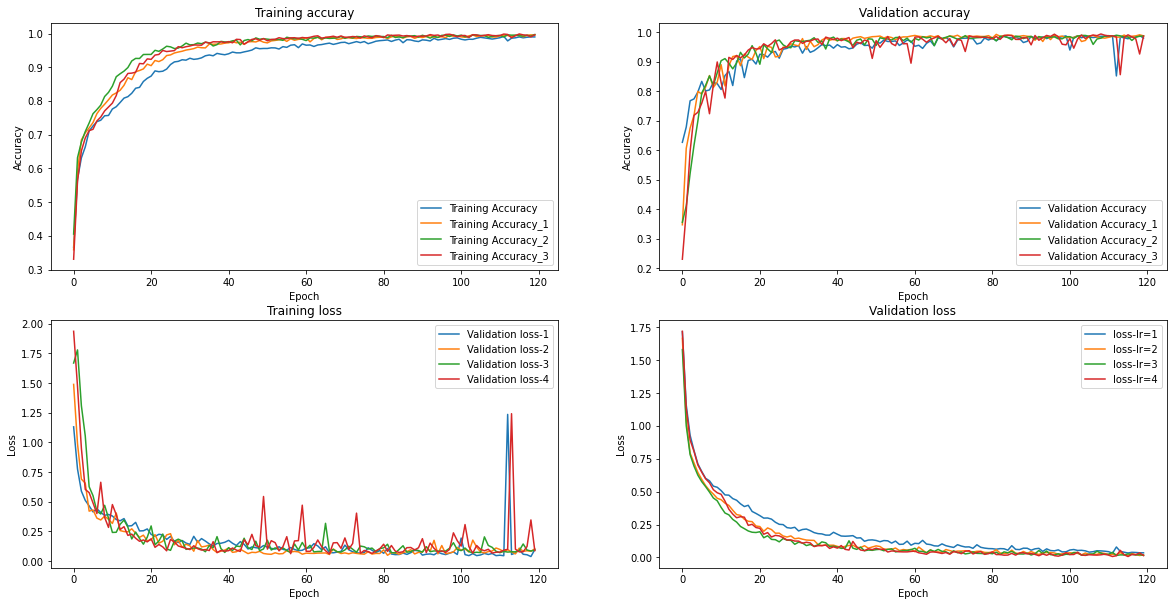

In [ ]:
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
################
  acc1 = history1.history['accuracy']
  val_acc1 = history1.history['val_accuracy']
  loss1 = history1.history['loss']
  val_loss1 = history1.history['val_loss']
  #######
  acc2 = history2.history['accuracy']
  val_acc2 = history2.history['val_accuracy']
  loss2 = history2.history['loss']
  val_loss2 = history2.history['val_loss']
  ############
  acc3 = history3.history['accuracy']
  val_acc3 = history3.history['val_accuracy']
  loss3 = history3.history['loss']
  val_loss3 = history3.history['val_loss']
  ###########
  """acc4 = history4.history['accuracy']
  val_acc4 = history4.history['val_accuracy']
  loss4 = history4.history['loss']
  val_loss4 = history4.history['val_loss']"""



  plt.figure(figsize=(20,15))
  epochs = range(len(acc))
  plt.subplot(321)
  plt.plot(epochs, acc, '', label = 'Training Accuracy')

  plt.plot(epochs, acc1, '', label = 'Training Accuracy_1')

  plt.plot(epochs, acc2, '', label = 'Training Accuracy_2')

  plt.plot(epochs, acc3, '', label = 'Training Accuracy_3')

  #plt.plot(epochs, acc4, '', label = 'Training Accuracy_4-lr=0.1')

  plt.title('Training accuray')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2,bottom=0.1)

  plt.subplot(322)
  plt.plot(epochs, val_acc, '', label= 'Validation Accuracy')

  plt.plot(epochs, val_acc1, '', label= 'Validation Accuracy_1')

  plt.plot(epochs, val_acc2, '', label= 'Validation Accuracy_2')

  plt.plot(epochs, val_acc3, '', label= 'Validation Accuracy_3')

  #plt.plot(epochs, val_acc4, '', label= 'Validation Accuracy_4-lr=0.1')

  plt.title(' Validation accuray')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2,bottom=0.1)

  plt.subplot(323)
  plt.plot(epochs, val_loss,'', label = 'Validation loss-1')
  plt.plot(epochs, val_loss1,'', label = 'Validation loss-2')
  plt.plot(epochs, val_loss2,'', label = 'Validation loss-3')
  plt.plot(epochs, val_loss3,'', label = 'Validation loss-4')
  #plt.plot(epochs, val_loss4,'', label = 'Validation loss-lr=0.1')
  #plt.plot(epochs, loss4,'r', label = 'loss')
  plt.title('Training loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2)


  plt.subplot(324)
  plt.plot(epochs, loss,'', label = 'loss-lr=1')
  plt.plot(epochs, loss1,'', label = 'loss-lr=2')
  plt.plot(epochs, loss2,'', label = 'loss-lr=3')
  plt.plot(epochs, loss3,'', label = 'loss-lr=4')
  #plt.plot(epochs, loss4,'', label = 'loss-lr=0.1')
  plt.title('Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2)
  #show the graph
  plt.show()

### make prdiction and do confusion matrix

In [ ]:
labeles = ['CBD','CB_Healthy','Healthy','Cercospora','Mold','Phoma','CLR']

### confusion matrix Training

In [ ]:
pred_tr = e_model.predict([x_tr,x_tr])
round_pred_tr = np.argmax(pred_tr,axis=-1)
y_tr_r = np.argmax(y_tr,axis=-1)
#print("Acuracy of the Testing is : " ,pred)

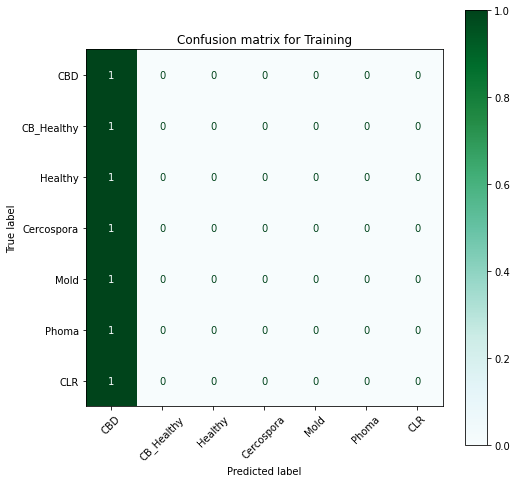

In [ ]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_tr_r, round_pred_tr,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Training")
plt.show()

In [ ]:
print(classification_report(y_tr_r,round_pred_tr))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       777
           1       0.99      1.00      0.99       666
           2       1.00      1.00      1.00       857
           3       1.00      1.00      1.00       647
           4       1.00      1.00      1.00       654
           5       1.00      1.00      1.00       649
           6       1.00      1.00      1.00       694

    accuracy                           1.00      4944
   macro avg       1.00      1.00      1.00      4944
weighted avg       1.00      1.00      1.00      4944



/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

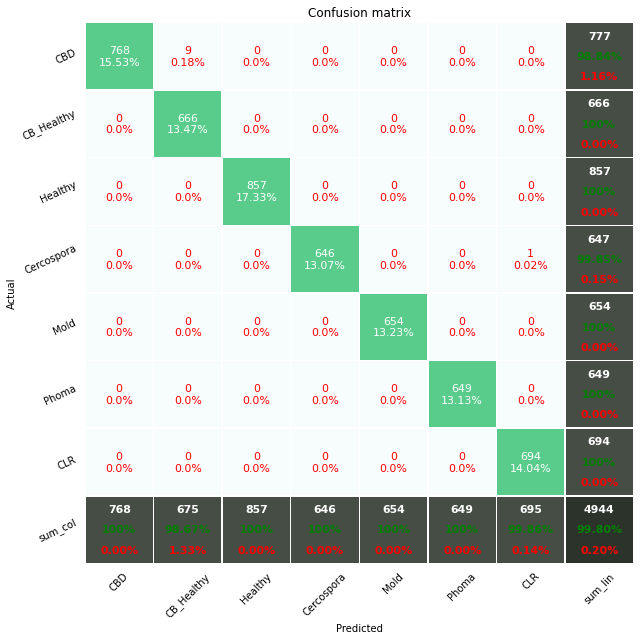

In [ ]:
pp_matrix_from_data(y_tr_r, round_pred_tr,cmap='BuGn',columns=labeles,figsize=[7,7],pred_val_axis='x')

### validation confusion matrix

In [ ]:
pred_v = e_model.predict([x_v,x_v])
round_pred_v = np.argmax(pred_v,axis=-1)
y_v_r = np.argmax(y_v,axis=-1)

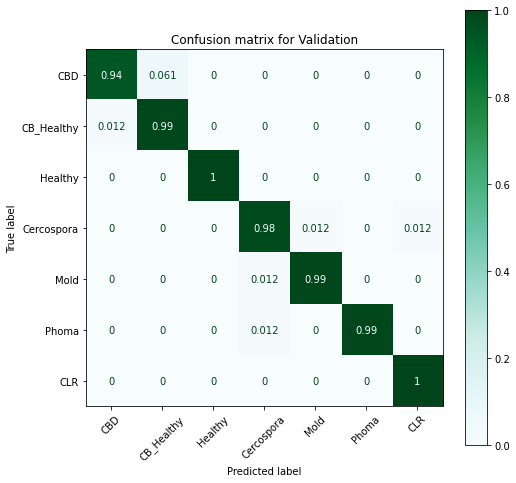

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        98
           1       0.93      0.99      0.96        83
           2       1.00      1.00      1.00       107
           3       0.98      0.98      0.98        81
           4       0.99      0.99      0.99        82
           5       1.00      0.99      0.99        81
           6       0.99      1.00      0.99        86

    accuracy                           0.98       618
   macro avg       0.98      0.98      0.98       618
weighted avg       0.98      0.98      0.98       618



In [ ]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_v_r, round_pred_v,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Validation")
plt.show()
print(classification_report(y_v_r,round_pred_v))

/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

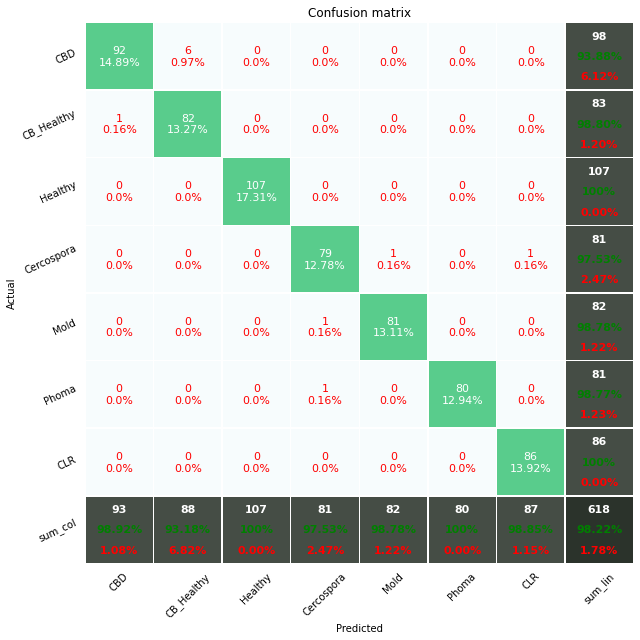

In [ ]:
pp_matrix_from_data(y_v_r, round_pred_v,cmap='BuGn',columns=labeles,figsize=[7,7],pred_val_axis='x')

### confusion matrix Testing

In [ ]:
pred_t = e_model.predict([x_tes,x_tes])
round_pred_t = np.argmax(pred_t,axis=-1)
y_tes_r = np.argmax(y_tes,axis=-1)

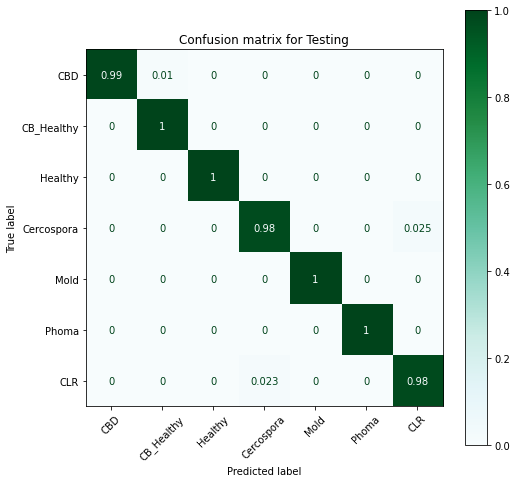

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       0.99      1.00      0.99        83
           2       1.00      1.00      1.00       107
           3       0.98      0.98      0.98        81
           4       1.00      1.00      1.00        82
           5       1.00      1.00      1.00        81
           6       0.98      0.98      0.98        87

    accuracy                           0.99       618
   macro avg       0.99      0.99      0.99       618
weighted avg       0.99      0.99      0.99       618



In [ ]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_tes_r, round_pred_t,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Testing")
plt.show()
print(classification_report(y_tes_r,round_pred_t))

/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

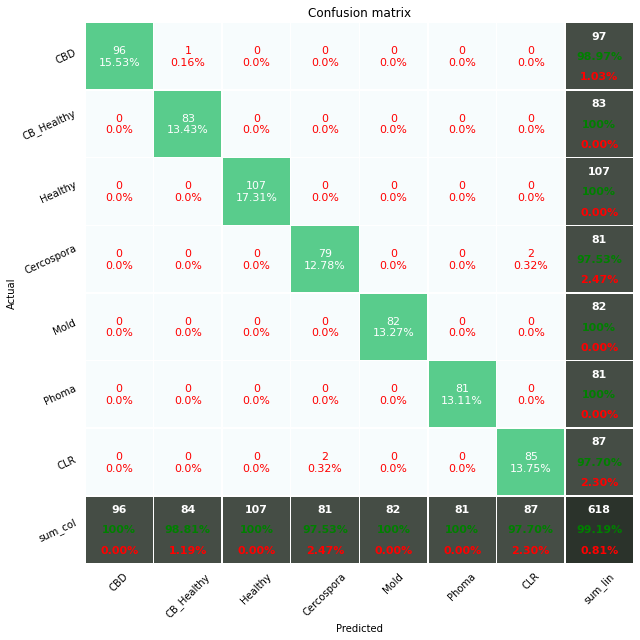

In [ ]:
pp_matrix_from_data(y_tes_r, round_pred_t,cmap='BuGn',columns=labeles,figsize=[7,7],pred_val_axis='x')